# 13 生成式对抗网络

《Generative Adversarial Networks》 https://arxiv.org/abs/1406.2661

## 13.1 生成式对抗网络的原理

生成式对抗网络包含一个生成模型(generative model, G)和一个判别模型(discriminative model, D)。

生成式对抗网络主要解决的问题是如何从训练样本中学习出新样本。生成模型就是负责训练出样本的分布，如果训练样本是图片就生成相似的图片，如果训练样本是文章句子就生成相似.  
生成式对抗网络的优化是一个二元极小极大博弈(minimax two-player game)问题，它的目的是使生成模型的输出在输入给判别模型时，判别模型很难判断是真实数据还是虚假数据。训练好的生成模型，有能力把一个噪声向量转化成和训练集类似的样本。

![aa](file:///home/tfb/dev/github/fatu/tensorflow_examples/notebooks/13.1-1.png)
<img src="file:///home/tfb/dev/github/fatu/tensorflow_examples/notebooks/13.1-1.png">

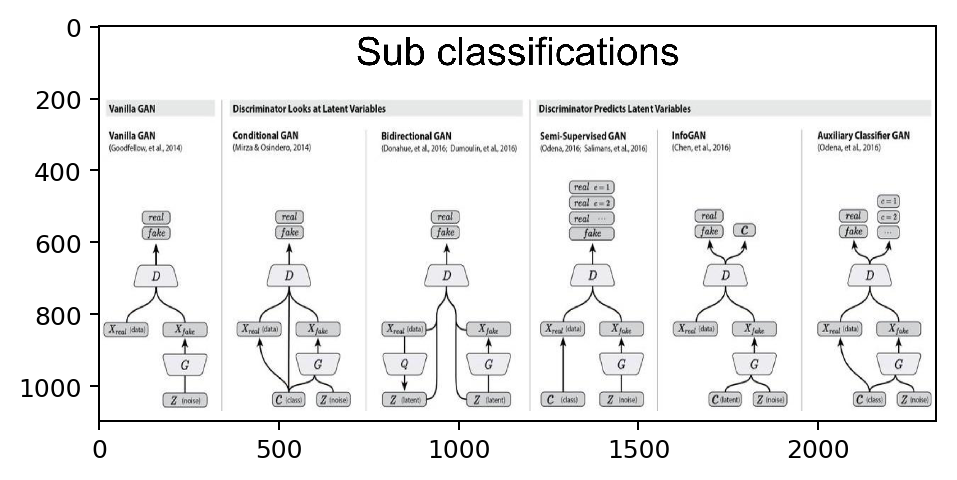

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
img=Image.open('/home/tfb/dev/github/fatu/tensorflow_examples/notebooks/13.1-1.png')
plt.figure("dog", dpi=180)
plt.imshow(img)
plt.show()

## 13.2 生成式对抗网络的应用

目前图像领域取得较多成果

## 13.3 生成式对抗网络的实现

AC-GAN：在MNIST数据集上实现生成式对抗网络  
参考代码：https://github.com/fchollet/keras/blob/master/examples/mnist_acgan.py

In [12]:
from __future__ import print_function

from collections import defaultdict
try:
    import cPickle as pickle
except ImportError:
    import pickle
from PIL import Image

from six.moves import range

import keras.backend as K
from keras.datasets import mnist
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np

np.random.seed(1337)

K.set_image_data_format('channels_first')

num_classes = 10

首先定义生成模型，目的是要生成一对(z, L)数据，其中z是噪声向量，L是（1,28,28)的图像空间：

In [13]:
def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 1, 28, 28)
    cnn = Sequential()

    cnn.add(Dense(1024, input_dim=latent_size, activation='relu'))
    cnn.add(Dense(128 * 7 * 7, activation='relu'))
    cnn.add(Reshape((128, 7, 7)))

    # 上采样，图像尺寸变为 14*14
    cnn.add(UpSampling2D(size=(2, 2)))
    cnn.add(Conv2D(256, 5, padding='same',
                   activation='relu',
                   kernel_initializer='glorot_normal'))

    # 上采样，图像尺寸变为 28*28
    cnn.add(UpSampling2D(size=(2, 2)))
    cnn.add(Conv2D(128, 5, padding='same',
                   activation='relu',
                   kernel_initializer='glorot_normal'))

    # 规约到1个通道
    cnn.add(Conv2D(1, 2, padding='same',
                   activation='tanh',
                   kernel_initializer='glorot_normal'))

    # 生成模型的输入层this is the z space commonly refered to in GAN papers
    latent = Input(shape=(latent_size, ))

    # 生成模型的输入层，标记this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    cls = Flatten()(Embedding(num_classes, latent_size,
                              embeddings_initializer='glorot_normal')(image_class))

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)

接下来定义判别模型，输入（1, 28, 28）的图片，输出有两个值，一个是判别模型认为这张图片是否是虚假图片，另一个是判别模型认为这张图片所属的分类

In [14]:
def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Conv2D(32, 3, padding='same', strides=2,
                   input_shape=(1, 28, 28)))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(64, 3, padding='same', strides=1))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(128, 3, padding='same', strides=2))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(256, 3, padding='same', strides=1))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))

    cnn.add(Flatten())

    image = Input(shape=(1, 28, 28))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(num_classes, activation='softmax', name='auxiliary')(features)

    return Model(image, [fake, aux])

训练的过程，我们进行50轮,并把权重保存下来，每轮也把虚假数据生成的图片保存下来，便于观察虚假数据的演化过程：

In [ ]:
if __name__ == '__main__':

    # batch and latent size taken from the paper
    epochs = 50
    batch_size = 100
    latent_size = 100

    # Adam parameters suggested in https://arxiv.org/abs/1511.06434
    adam_lr = 0.0002
    adam_beta_1 = 0.5

    # build the discriminator
    discriminator = build_discriminator()
    discriminator.compile(
        optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )

    # build the generator
    generator = build_generator(latent_size)

    latent = Input(shape=(latent_size, ))
    image_class = Input(shape=(1,), dtype='int32')

    # get a fake image
    fake = generator([latent, image_class])

    # we only want to be able to train generation for the combined model
    discriminator.trainable = False
    fake, aux = discriminator(fake)
    combined = Model([latent, image_class], [fake, aux])

    combined.compile(
        optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )

    # get our mnist data, and force it to be of shape (..., 1, 28, 28) with
    # range [-1, 1]
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis=1)

    x_test = (x_test.astype(np.float32) - 127.5) / 127.5
    x_test = np.expand_dims(x_test, axis=1)

    num_train, num_test = x_train.shape[0], x_test.shape[0]

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    for epoch in range(1, epochs + 1):
        print('Epoch {}/{}'.format(epoch, epochs))

        num_batches = int(x_train.shape[0] / batch_size)
        progress_bar = Progbar(target=num_batches)

        epoch_gen_loss = []
        epoch_disc_loss = []

        for index in range(num_batches):
            # generate a new batch of noise
            noise = np.random.uniform(-1, 1, (batch_size, latent_size))

            # get a batch of real images
            image_batch = x_train[index * batch_size:(index + 1) * batch_size]
            label_batch = y_train[index * batch_size:(index + 1) * batch_size]

            # sample some labels from p_c
            sampled_labels = np.random.randint(0, num_classes, batch_size)

            # generate a batch of fake images, using the generated labels as a
            # conditioner. We reshape the sampled labels to be
            # (batch_size, 1) so that we can feed them into the embedding
            # layer as a length one sequence
            generated_images = generator.predict(
                [noise, sampled_labels.reshape((-1, 1))], verbose=0)

            x = np.concatenate((image_batch, generated_images))
            y = np.array([1] * batch_size + [0] * batch_size)
            aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

            # see if the discriminator can figure itself out...
            epoch_disc_loss.append(discriminator.train_on_batch(x, [y, aux_y]))

#             # make new noise. we generate 2 * batch size here such that we have
#             # the generator optimize over an identical number of images as the
#             # discriminator
#             noise = np.random.uniform(-1, 1, (2 * batch_size, latent_size))
#             sampled_labels = np.random.randint(0, num_classes, 2 * batch_size)

#             # we want to train the generator to trick the discriminator
#             # For the generator, we want all the {fake, not-fake} labels to say
#             # not-fake
#             trick = np.ones(2 * batch_size)

#             epoch_gen_loss.append(combined.train_on_batch(
#                 [noise, sampled_labels.reshape((-1, 1))],
#                 [trick, sampled_labels]))
            
            
            for i in range(32):
                # make new noise. we generate 2 * batch size here such that we have
                # the generator optimize over an identical number of images as the
                # discriminator
                noise = np.random.uniform(-1, 1, (2 * batch_size, latent_size))
                sampled_labels = np.random.randint(0, num_classes, 2 * batch_size)
 
                # we want to train the generator to trick the discriminator
               # For the generator, we want all the {fake, not-fake} labels to say
                # not-fake
                trick = np.ones(2 * batch_size)

                epoch_gen_loss.append(combined.train_on_batch(
                    [noise, sampled_labels.reshape((-1, 1))],
                    [trick, sampled_labels]))

                if epoch_gen_loss[-1][1] <= epoch_disc_loss[-1][1]:
                    break

            progress_bar.update(index + 1)

        print('Testing for epoch {}:'.format(epoch))

        # evaluate the testing loss here

        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (num_test, latent_size))

        # sample some labels from p_c and generate images from them
        sampled_labels = np.random.randint(0, num_classes, num_test)
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=False)

        x = np.concatenate((x_test, generated_images))
        y = np.array([1] * num_test + [0] * num_test)
        aux_y = np.concatenate((y_test, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        discriminator_test_loss = discriminator.evaluate(
            x, [y, aux_y], verbose=False)

        discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

        # make new noise
        noise = np.random.uniform(-1, 1, (2 * num_test, latent_size))
        sampled_labels = np.random.randint(0, num_classes, 2 * num_test)

        trick = np.ones(2 * num_test)

        generator_test_loss = combined.evaluate(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels], verbose=False)

        generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

        # generate an epoch report on performance
        train_history['generator'].append(generator_train_loss)
        train_history['discriminator'].append(discriminator_train_loss)

        test_history['generator'].append(generator_test_loss)
        test_history['discriminator'].append(discriminator_test_loss)

        print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
            'component', *discriminator.metrics_names))
        print('-' * 65)

        ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
        print(ROW_FMT.format('generator (train)',
                             *train_history['generator'][-1]))
        print(ROW_FMT.format('generator (test)',
                             *test_history['generator'][-1]))
        print(ROW_FMT.format('discriminator (train)',
                             *train_history['discriminator'][-1]))
        print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

        # save weights every epoch
        generator.save_weights(
            'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
        discriminator.save_weights(
            'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

        # generate some digits to display
        num_rows = 10
        noise = np.random.uniform(-1, 1, (num_rows * num_classes, latent_size))

        sampled_labels = np.array([
            [i] * num_rows for i in range(num_classes)
        ]).reshape(-1, 1)

        # get a batch to display
        generated_images = generator.predict(
            [noise, sampled_labels], verbose=0)

        # arrange them into a grid
        img = (np.concatenate([r.reshape(-1, 28)
                               for r in np.split(generated_images, num_classes)
                               ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

        Image.fromarray(img).save(
            'plot_epoch_{0:03d}_generated.png'.format(epoch))

    pickle.dump({'train': train_history, 'test': test_history},
                open('acgan-history.pkl', 'wb'))

Epoch 1/50
600/600 [==============================] - 141s 235ms/step
Testing for epoch 1:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.23 | 0.77            | 0.45 
generator (test)       | 0.67 | 0.67            | 0.00 
discriminator (train)  | 1.20 | 0.77            | 0.44 
discriminator (test)   | 0.88 | 0.76            | 0.12 
Epoch 2/50
600/600 [==============================] - 148s 247ms/step
Testing for epoch 2:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 0.75 | 0.73            | 0.01 
generator (test)       | 0.64 | 0.63            | 0.01 
discriminator (train)  | 0.83 | 0.72            | 0.11 
discriminator (test)   | 0.83 | 0.75            | 0.07 
Epoch 3/50
600/600 [==============================] - 150s 251ms/step
Testing for epoch 3:
component        

训练结束后，会创建3类文件
* params_discriminator_epoch_{{epoch_number}}.hdf5:判别模型的权重参数
* params_generator_epoch_{{epoch_number}}.hdf5:生成模型的权重参数
* plot_epoch_{{epoch_number}}.hdf5:产生的一些虚假数据的图片

在5轮后，可以看到一些差不多的图像  
在训练15轮后，可以得到一些良好的图像  
事实上，在15轮左右，训练损失就已经收敛到纳什均衡点（Nash equilibrium point）  

## 13.4 生成式对抗网络的改进

生成式对抗网络(generative adversarial network, GAN)在无监督学习上是非常有效的。但是，常规的生成式对抗网络的判别器使用的是Sigmoid交叉熵损失函数，这在学习过程中可能导致梯度消失。生成式对抗网络的一个改进是Wasserstein生成式对抗网络（Wasserstein generative adversarial network, WGAN), 它使用Wasserstein距离度量而不是Jensen-Shannon散度(Jensen-Shannon divergence, JSD).生成式对抗网络的另一个改进是使用最小二乘生成式对抗网络（least squares generative adversarial network, LSGAN),它的判别模型采用最小平方损失函数（least squares loss function).关于更多它们之前的区别，《f-GAN: Training Generative Neural Samplers using Variational Divergence Minimization》.